In [3]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs187-2021/lab1-3.git .tmp
 mv .tmp/tests ./
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [4]:
# Initialize Otter
import otter
grader = otter.Notebook()

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# CS187
## Lab 1-3 – Naive Bayes classification

In this lab, you'll apply the naive Bayes method to the _Federalist_ papers' authorship attribution problem.

After this lab, you should be able to

* Derive the basic equations for the naive Bayes classification method;
* Estimate the parameters for the naive Bayes model;
* Determine where use of the "log trick" is indicated, and apply it.

New bits of Python used for the first time in the _solution set_ for this lab, and which you may therefore find useful:

* [`math.log2`](https://docs.python.org/3.8/library/math.html#math.log2)

# Preparation – Loading packages and data

In [5]:
%matplotlib inline
import json
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('tableau-colorblind10')
import torch
import wget

from collections import defaultdict

In [6]:
# Download and read the Federalist data from the json file
os.makedirs('data', exist_ok=True)
wget.download('https://github.com/nlp-course/data/raw/master/Federalist/federalist_data.json', out='data/')
with open('data/federalist_data.json', 'r') as fin:
    dataset = json.load(fin)

100% [..........................................................] 16713 / 16713

In [17]:
# As before, we extract the papers by either of Madison and Hamilton
# to serve as training data.
training = list(filter(lambda ex: ex['authors'] in ['Madison', 'Hamilton'],
                       dataset))

[{'authors': 'Hamilton',
  'counts': [9, 6, 2, 0],
  'number': '1',
  'title': 'General Introduction'},
 {'authors': 'Hamilton',
  'counts': [2, 4, 7, 0],
  'number': '6',
  'title': 'Concerning Dangers from Dissensions Between the States'},
 {'authors': 'Hamilton',
  'counts': [13, 11, 9, 0],
  'number': '7',
  'title': 'The Same Subject Continued: Concerning Dangers from Dissensions Between the States'},
 {'authors': 'Hamilton',
  'counts': [11, 3, 1, 0],
  'number': '8',
  'title': 'The Consequences of Hostilities Between the States'},
 {'authors': 'Hamilton',
  'counts': [9, 4, 3, 0],
  'number': '9',
  'title': 'The Union as a Safeguard Against Domestic Faction and Insurrection'},
 {'authors': 'Madison',
  'counts': [18, 0, 4, 0],
  'number': '10',
  'title': 'The Same Subject Continued: The Union as a Safeguard Against Domestic Faction and Insurrection'},
 {'authors': 'Hamilton',
  'counts': [5, 6, 5, 0],
  'number': '11',
  'title': 'The Utility of the Union in Respect to Commer

# The Naive Bayes method reviewed
A quick review of the Naive Bayes (NB) method for text classification: In classification tasks, we're given a representation of some text as a vector $\mathbf{x} = \langle x_1, x_2, \ldots, x_m \rangle$ of feature values, and we'd like to determine which of a set of classes $\{ y_1, y_2, \ldots, y_k \}$ the text should be classified as. 

> In the case at hand, the Federalist Papers, for a given document, we'll take $\mathbf{x} = \langle x_1, x_2, \ldots, x_m \rangle$ to be the sequence of words in the document, so each $x_i$ corresponds to a single word token.

We might naturally think to choose that class that has the highest probability of being correct, that is, the class $y_i$ that maximizes $Pr(y_i \mid \mathbf{x})$.

By Bayes rule (this is the "Bayes" part in the name "Naive Bayes"), 

\begin{align*}
\argmax{i} \Prob(y_i \given \vect{x}) 
&= \argmax{i} \frac{\Prob(\vect{x} \given y_i) \cdot \Prob(y_i)}{\Prob(\vect{x})} \\
&= \argmax{i} \Prob(\vect{x} \given y_i) \cdot \Prob(y_i)
\end{align*}

<!-- BEGIN QUESTION -->

**Question**: Why can we drop the denominator in the last step of this derivation?
<!--
BEGIN QUESTION
name: open_response_denominator
manual: true
-->

_Because Pr(x) will be constant as we compute through different y_i, as x is the document vector and we are only working with one document at a time._

<!-- END QUESTION -->



We use the following terminology: $\Prob(y_i)$ is the _prior probability_. $\Prob(\vect{x} \given y_i)$ is the _likelihood_. 
$\Prob(y_i \given \vect{x})$ is the _posterior probability_.

By the chain rule, 

\begin{align*}
\Prob(\vect{x} \given y_i) &= \Prob(x_1, \ldots, x_m \given y_i) \\
&= \Prob(x_1 \given y_i) \cdot \Prob(x_2, \ldots, x_m \given x_1, y_i) \\
&= \Prob(x_1 \given y_i) \cdot \Prob(x_2 \given x_1, y_i) \cdot \Prob(x_3, \ldots,
x_m \given x_1, x_2, y_i) \\
\cdots &= \prod_{j=1}^m \Prob(x_j \given x_1, \ldots, x_{j-1}, y_i)
\end{align*}

We further assume that each feature $x_i$ is independent of all the others given the class. (That's the "naive" part.) So 

$$
\Prob(x_j \given x_1, \ldots, x_{j-1}, y_i) \approx \Prob(x_j \given y_i)
$$

Using this approximation, we'll calculate instead the class as per the following maximization:

$$
\argmax{i} \Prob(y_i \given \vect{x}) \approx \argmax{i} \Prob(y_i) \cdot \prod_{j=1}^m \Prob(x_j \given y_i)
$$

> This independence assumption, in the text case, amounts to ignoring the order and even the cooccurence of words in a document, a quite aggressive and unrealistic independence assumption indeed.

All we need, then, for the Naive Bayes classification method is values for $\Prob(y_i)$ and $\Prob(x_j \given y_i)$ for each feature $x_j$ and each class $y_i$. These constitute the parameters of the model, which we will learn from a training dataset.

# Naive Bayes for the Federalist papers

In applying Naive Bayes to an example in the Federalist dataset, we'll take the $x_i$ to be the _tokens in the example_. To make the calculations easier, in this lab, we won't use _all_ of the tokens, just the tokens of the four word types we've been attending to, but in an actual application of NB, we'd use (essentially) all of the word types. As a reminder,

In [34]:
keywords = ['on', 'upon', 'there', 'whilst']

and the two class labels are

In [35]:
classes = ['Hamilton', 'Madison']

### Estimating the prior probabilities

Let's start with the prior probabilities $\Prob(y_i)$. In our case, there are only two class labels, for Hamilton and Madison. We estimate the probability of a class $y_i$ by simply counting the proportion of examples that are labeled with that class. (This estimate is the *sample probability*, which is also referred to as the *maximum likelihood estimate* for reasons we'll skip for the moment.) That is, we estimate 

$$ \Prob(y_i) \approx \frac{\cnt{y_i}}{N} $$

where $N$ is the number of training examples, and $\cnt{y_i}$ is the number of training examples of class $y_i$.

In the cell below, write code to count how many of the training examples are labeled with Hamilton and how many are labeled with Madison. Use these to provide estimates of the Hamilton and Madison prior probabilities.
<!--
BEGIN QUESTION
name: priors
-->

In [36]:
#TODO - Calculate the prior probabilities for Madison and Hamilton as floats.
prior_madison = len(list(filter(lambda ex: ex['authors'] in ['Madison'],
                       training)))/len(training)
prior_hamilton = len(list(filter(lambda ex: ex['authors'] in ['Hamilton'],
                       training)))/len(training)

In [37]:
grader.check("priors")

All tests passed!

In [38]:
print(f"Madison  prior: {prior_madison:.4f}\n"
      f"Hamilton prior: {prior_hamilton:.4f}")

Madison  prior: 0.2273
Hamilton prior: 0.7727


<!-- BEGIN QUESTION -->

**Question:** What do these probabilities tell us about how we might predict the class of a _Federalist_ document _prior_ to looking at the actual content of the document? (That's why these probabilities are called "priors".)
<!--
BEGIN QUESTION
name: open_response_priors
manual: true
-->

_All else equal, we are more likely to predict that Hamilton is the author, since the prior probability for Hamilton is greater._

<!-- END QUESTION -->



## Estimating the likelihood probabilities

Now for the likelihood probabilities, the conditional probability of a word given a class. For each likelihood $\Prob(x_j \given y_i)$, we need to estimate a value. We'll do so by simply counting the number of training examples with feature value $x_j$ that are labeled $y_i$ (notated as $\cnt{x_j, y_i}$) as a proportion of the overall number of words labeled as $y_i$, that is,

$$ \Prob(x_j \given y_i) \approx \frac{\cnt{x_j, y_i}}{\sum_k \cnt{x_k, y_i}} $$

Again, for the text case, each token counts as an instance of the corresponding word type in a training example. Note that $\sum_k \cnt{x_k, y_i}$ is not the same as $\cnt{y_i}$.
 
We've provided a small table that shows, for each label (author) and each of the four word types of interest, how many tokens of the type occurred in training examples with that label.

In [23]:
def counts(dataset, label, index):
    """Returns the total count for `index` for examples with the 
       given `label`"""
    return sum([example['counts'][index] 
                for example in dataset 
                if example['authors'] == label])

# print a table header
print(f"{'':10}", end="")
for i in range(4):
    print(f"{keywords[i]:>8}", end="")
print()
# print table entries for each label
for label in classes:
    print(f"{label:10}", end="")
    for i in range(4):
        print(f"{counts(training, label, i):8}", end="")
    print()

                on    upon   there  whilst
Hamilton       390     377     369       1
Madison        308       7      32      12


Given the counts in this table, what would an estimate be for the probability that a given word would be "whilst" given that the document was authored by Madison, that is, $\Prob(\mathrm{whilst} \given \mathrm{Madison})$?
<!--
BEGIN QUESTION
name: prob_whilst_madison
-->

In [43]:
#TODO - Define this variable to be the specified probability.
prob_whilst_madison = counts(training, 'Madison', 3)/sum(counts(training, 'Madison', index) for index in range(4))
prob_whilst_madison

0.033426183844011144

In [44]:
grader.check("prob_whilst_madison")

All tests passed!

What about the probability $\Prob(\mathrm{on} \given \mathrm{Hamilton})$?
<!--
BEGIN QUESTION
name: prob_on_hamilton
-->

In [46]:
#TODO - Define this variable to be the specified probability.
prob_on_hamilton = counts(training, 'Hamilton', 0)/sum(counts(training, 'Hamilton', index) for index in range(4))
prob_on_hamilton

0.34300791556728233

In [47]:
grader.check("prob_on_hamilton")

All tests passed!

Consider a sample text 

> **whilst** depending neither **on** the American government nor **on** the British

What would the Naive Bayes method estimate be for the likelihood of this sentence if it was by Hamilton? By Madison? (You should of course ignore all the tokens in our little sample text except for tokens of the four keyword types. (We've boldfaced their occurrences.) With a full-blown NB analysis, we'd be using *all* of the words in the text.)
<!--
BEGIN QUESTION
name: likelihoods
-->

In [48]:
prob_on_madison = counts(training, 'Madison', 0)/sum(counts(training, 'Madison', index) for index in range(4))
prob_whilst_hamilton = counts(training, 'Hamilton', 3)/sum(counts(training, 'Hamilton', index) for index in range(4))

In [49]:
#TODO - Define the variables to be the corresponding likelihood probabilities.
likelihood_hamilton = prob_whilst_hamilton * (prob_on_hamilton ** 2)
likelihood_madison = prob_whilst_madison * (prob_on_madison ** 2)

In [50]:
grader.check("likelihoods")

All tests passed!

In [51]:
print(f"Madison  likelihood: {likelihood_madison:4f}\n"
      f"Hamilton likelihood: {likelihood_hamilton:4f}")

Madison  likelihood: 0.024604
Hamilton likelihood: 0.000103


## Posterior probabilities

We're almost there. We simply need to combine the prior probabilities and the likelihood probabilities for each class to form the posterior, and select the largest one. As a reminder, we don't actually calculate the posterior _probability_ because we aren't dividing through by $\Prob(\vect{x})$. Instead, we get something like a posterior _score_.

Calculate the posteriors for the two classes, and then specify which class – Hamilton or Madison – the NB method would predict for the sample text.
<!--
BEGIN QUESTION
name: posteriors
-->

In [56]:
#TODO - Define the variables to be the corresponding posterior probabilities, 
#       and the classification of the sample phrase.
posterior_madison = prior_madison * likelihood_madison
posterior_hamilton = prior_hamilton * likelihood_hamilton
sample_classification = 'Madison' if posterior_madison > posterior_hamilton else 'Hamilton'

In [57]:
grader.check("posteriors")

All tests passed!

In [58]:
print(f"Madison  posterior: {posterior_madison:4f}\n"
      f"Hamilton posterior: {posterior_hamilton:4f}\n"
      f"Sample classification: {sample_classification}")

Madison  posterior: 0.005592
Hamilton posterior: 0.000080
Sample classification: Madison


<!-- BEGIN QUESTION -->

**Question:** Is the NB-predicted classification the same as or different from the classification based on the priors? Why?
<!--
BEGIN QUESTION
name: open_response_nb_v_priors
manual: true
-->

_No, the priors predicted Hamilton instead Madison. This is because P(whilst|Hamilton) is very low._

<!-- END QUESTION -->



## A practical issue

The computations of what we've been calling the posterior scores
$$\Prob(y_i \given \vect{x}) \approx \Prob(y_i) \cdot \prod_{j=1}^m \Prob(x_j \given y_i)$$
involve the multiplication of many extremely small numbers. This is a recipe for [_arithmetic underflow_](https://en.wikipedia.org/wiki/Arithmetic_underflow), leading to garbage outputs.

Instead, rather than maximizing the posterior, we can maximize its logarithm. Since the logarithm function is monotonic (see the next cell for a figure), whichever $i$ maximizes the posterior maximizes its log as well.

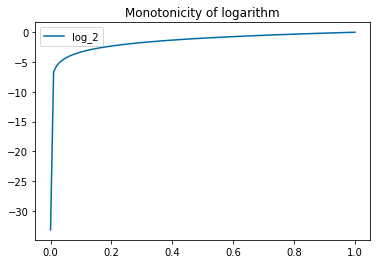

In [60]:
def log_plot():
    x = torch.linspace(1e-10, 1, 100)
    fig, ax = plt.subplots()
    ax.plot(x, torch.log2(x), label = "log_2")
    plt.title("Monotonicity of logarithm")
    plt.legend()
    
log_plot()

The log of the posterior is
$$\log \left(\Prob(y_i) \cdot \prod_{j=1}^m \Prob(x_j \given y_i)\right)
      = \log\Prob(y_i) + \sum_{j=1}^m \log\Prob(x_j \given y_i)$$
so that the calculation now involves the sum of a bunch of numbers rather than the product. In practice, this computation is much more robust.

> A log-of-probability value is referred to, colloquially if not quite accurately, as a *logit*, because of a resemblance to the values of [the logit function](https://en.wikipedia.org/wiki/Logit).

Calculate the log of the posterior for Madison for the sample text by summing up all of the pertinent logits, and similarly for Hamilton. Use the base 2 logarithm.
<!--
BEGIN QUESTION
name: log_posteriors
-->

In [64]:
#TODO - Calculate the log of the posterior for Madison by summing up all 
#       of the pertinent parts.
log_posterior_madison = math.log2(prior_madison) + math.log2(prob_whilst_madison) + math.log2(prob_on_madison) * 2
log_posterior_hamilton = math.log2(prior_hamilton) + math.log2(prob_whilst_hamilton) + math.log2(prob_on_hamilton) * 2

In [65]:
grader.check("log_posteriors")

All tests passed!

In [66]:
print(f"Madison  log posterior: {log_posterior_madison:8.3f}\n"
      f"Hamilton log posterior: {log_posterior_hamilton:8.3f}")

Madison  log posterior:   -7.482
Hamilton log posterior:  -13.610


<!-- BEGIN QUESTION -->

**Question:** Which one of the two is larger? Does this accord with your expectation?
<!--
BEGIN QUESTION
name: open_response_posterior
manual: true
-->

_The log of the posterior for Madison is larger, which is expected because the posterior for Madison in larger and the log function is monotonic increasing._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Lab debrief – for consensus submission only

**Question:** We're interested in any thoughts your group has about this lab so that we can improve this lab for later years, and to inform later labs for this year. Please list any issues that arose or comments you have to improve the lab. Useful things to comment on include the following: 

* Was the lab too long or too short?
* Were the readings appropriate for the lab? 
* Was it clear (at least after you completed the lab) what the points of the exercises were? 
* Are there additions or changes you think would make the lab better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# End of lab 3

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [67]:
grader.check_all()

likelihoods:

    All tests passed!
    

log_posteriors:

    All tests passed!
    

posteriors:

    All tests passed!
    

priors:

    All tests passed!
    

prob_on_hamilton:

    All tests passed!
    

prob_whilst_madison:

    All tests passed!